## Setup and Imports

This section includes the necessary imports for a deep learning project using TensorFlow and Keras, including data loading and preprocessing, model creation, and utilities for visualization and numerical operations. It also sets a random seed for reproducibility of results.


In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(1000)

## Data Preparation and Optimizer Configuration

This section initializes the dimensionality for the generator's input noise vector, loads the MNIST dataset, preprocesses it by normalizing and reshaping the images for input into the neural network. It also configures the Adam optimizer with specific learning rate and beta parameters for stable training.


In [2]:
randomDim = 10
(X_train, _), (_, _) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5) / 127.5

X_train =  X_train.reshape(60000, 28 * 28)

adam = Adam(learning_rate=0.0002, beta_1=0.5)

## Generator Architecture

This section defines the architecture of the generator model for the GAN. It uses a `Sequential` model from Keras, starting with an input layer that takes a noise vector of a predefined dimension. The model includes several dense layers with LeakyReLU activation functions for non-linearity, and it outputs a vector reshaped into the dimensions of a flattened MNIST image, using a `tanh` activation function to normalize the output.


In [3]:
generator = Sequential()
generator.add(Dense(256, input_dim = randomDim))
generator.add(LeakyReLU(.2))
generator.add(Dense(512))
generator.add(LeakyReLU(.2))
generator.add(Dense(1024))
generator.add(LeakyReLU(.2))
generator.add(Dense(784, activation='tanh'))

## Discriminator Architecture

This section outlines the creation of the discriminator model within the GAN framework. The discriminator is built as a `Sequential` model in Keras, starting from an input layer designed to take flattened MNIST images. It includes dense layers with LeakyReLU activations and dropout for regularization, aimed at distinguishing between real and generated images. The final layer uses a `sigmoid` activation function to output a probability indicating the authenticity of the input image. The model is compiled with a binary crossentropy loss function and the previously defined Adam optimizer.


In [4]:
discriminator = Sequential()
discriminator.add(Dense(1024, input_dim = 784, kernel_initializer=initializers.RandomNormal(stddev = .02)))
discriminator.add(LeakyReLU(.2))
discriminator.add(Dropout(.3))
discriminator.add(Dense(512))
discriminator.add(LeakyReLU(.2))
discriminator.add(Dropout(.3))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(.2))
discriminator.add(Dropout(.3))
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss = 'binary_crossentropy', optimizer=adam)

## GAN Integration and Compilation

This section configures the Generative Adversarial Network (GAN) by integrating the previously defined generator and discriminator models. It starts by setting the discriminator's `trainable` attribute to `False` to freeze its weights during the GAN training phase, ensuring only the generator's weights are updated. The GAN model is then constructed by specifying the generator's input noise as the input and the discriminator's output as the final output. This integrated model is compiled with a binary crossentropy loss function and the Adam optimizer. Additionally, lists are initialized for tracking the loss of the discriminator and generator over the training epochs.


In [5]:
discriminator.trainable = False
ganInput = Input(shape = (randomDim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs = ganInput, outputs = ganOutput)
gan.compile(loss = 'binary_crossentropy', optimizer=adam)
dLosses = []
gLosses = []

## Visualization Utilities

This section contains utility functions for visualizing the training progress of the GAN. `plotLoss` function plots the discriminator and generator loss as a function of epochs, providing insights into the training dynamics and stability. `saveGeneratedImages` function generates a grid of images from the generator's output, given a sample of noise vectors, and saves these images to disk. These functions are crucial for monitoring the GAN's learning process and visually assessing the quality of generated images over time.


In [6]:
# Plot the loss from each batch
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminative loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('image_my/gan_loss_epoch_%d.png' % epoch)

# Create a wall of generated MNIST images
def saveGeneratedImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10)): 
    noise = np.random.normal(0, 1, size=[examples, randomDim])
    generatedImages = generator.predict(noise)
    generatedImages = generatedImages.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.suptitle('Epoch_%d' % epoch , fontsize=32, color = 'blue')
    plt.subplots_adjust(top=.95)
    print('save fig')
    plt.savefig('image_my/gan_generated_image_epoch_%d.png' % epoch)

## Training Loop

This section details the training loop for the GAN, including setting up epochs, batch sizes, and the process of training both the discriminator and generator within each epoch. It iterates through the dataset in batches, generates synthetic images using the generator, mixes these with real images, and then trains the discriminator to distinguish between real and fake images. Subsequently, it trains the generator to fool the discriminator, using a fixed label indicating that all images are real. The losses for both networks are recorded after each batch, and visual feedback is provided periodically by saving generated images and plotting the loss history. This iterative training approach is essential for the adversarial training process, aiming to improve the generator's ability to produce realistic images.


In [7]:
def train(epochs=1, batchSize=128):
    batchCount = int(X_train.shape[0] / batchSize)
    print ('Epochs:', epochs)
    print ('Batch size:', batchSize)
    print ('Batches per epoch:', batchCount)

    for e in range(1, epochs+1):
        print ('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in range(batchCount):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)]

            # Generate fake MNIST images
            generatedImages = generator.predict(noise)
            # print np.shape(imageBatch), np.shape(generatedImages)
            X = np.concatenate([imageBatch, generatedImages])

            # Labels for generated and real data
            yDis = np.zeros(2*batchSize)
            # One-sided label smoothing
            yDis[:batchSize] = 0.9

            # Train discriminator
            discriminator.trainable = True
            dloss = discriminator.train_on_batch(X, yDis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            yGen = np.ones(batchSize)
            discriminator.trainable = False
            gloss = gan.train_on_batch(noise, yGen)

        # Store loss of most recent batch from this epoch
        dLosses.append(dloss)
        gLosses.append(gloss)

        if e == 1 or e % 20 == 0:
            saveGeneratedImages(e)
            

    # Plot losses from every epoch
    plotLoss(e)

## Train Model

Epochs: 100
Batch size: 128
Batches per epoch: 468
--------------- Epoch 1 ---------------
save fig
--------------- Epoch 2 ---------------
--------------- Epoch 3 ---------------
--------------- Epoch 4 ---------------
--------------- Epoch 5 ---------------
--------------- Epoch 6 ---------------
--------------- Epoch 7 ---------------
--------------- Epoch 8 ---------------
--------------- Epoch 9 ---------------
--------------- Epoch 10 ---------------
--------------- Epoch 11 ---------------
--------------- Epoch 12 ---------------
--------------- Epoch 13 ---------------
--------------- Epoch 14 ---------------
--------------- Epoch 15 ---------------
--------------- Epoch 16 ---------------
--------------- Epoch 17 ---------------
--------------- Epoch 18 ---------------
--------------- Epoch 19 ---------------
--------------- Epoch 20 ---------------
save fig
--------------- Epoch 21 ---------------
--------------- Epoch 22 ---------------
--------------- Epoch 23 -------------

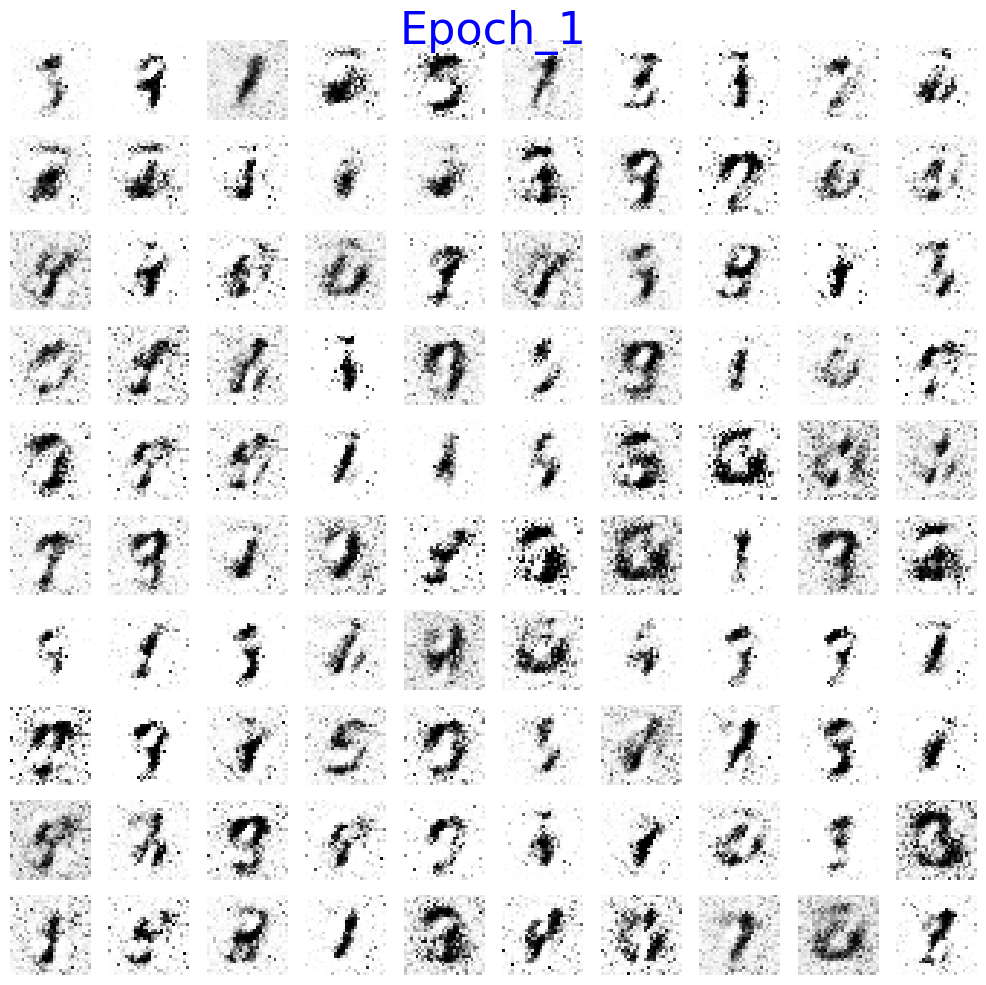

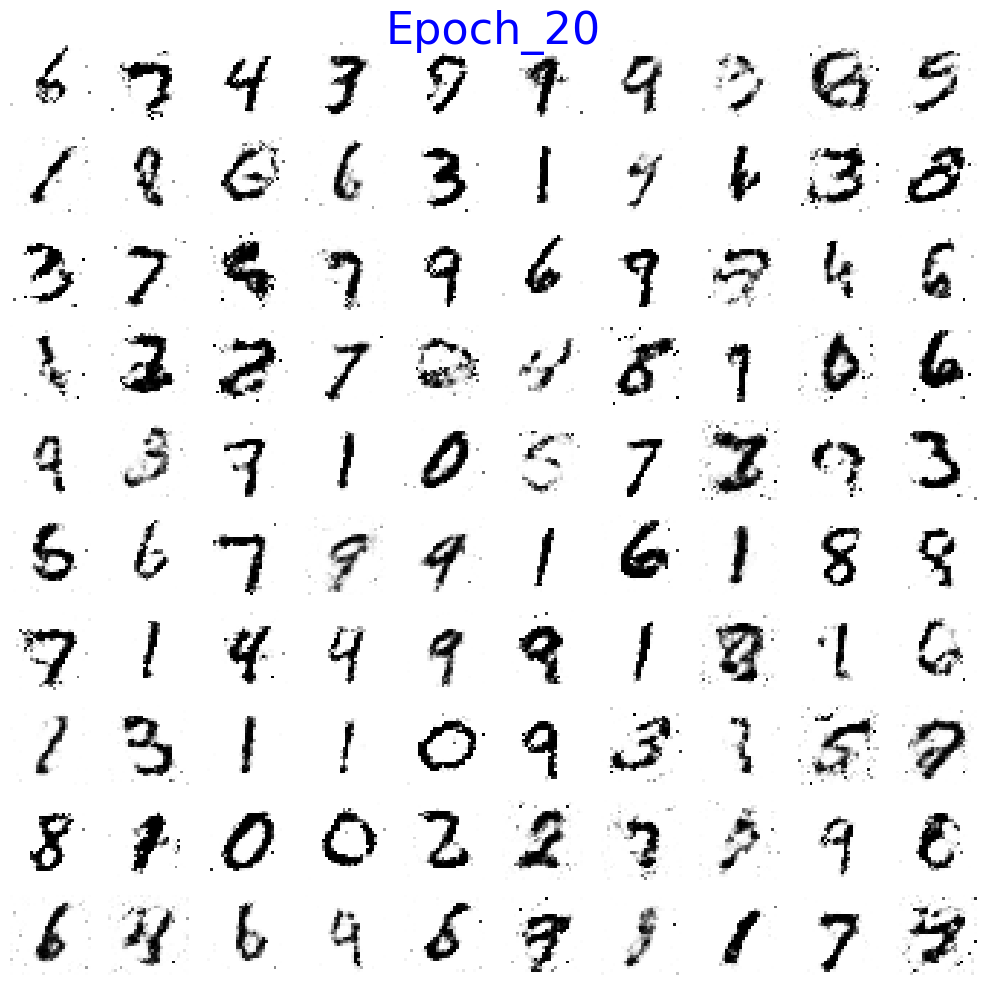

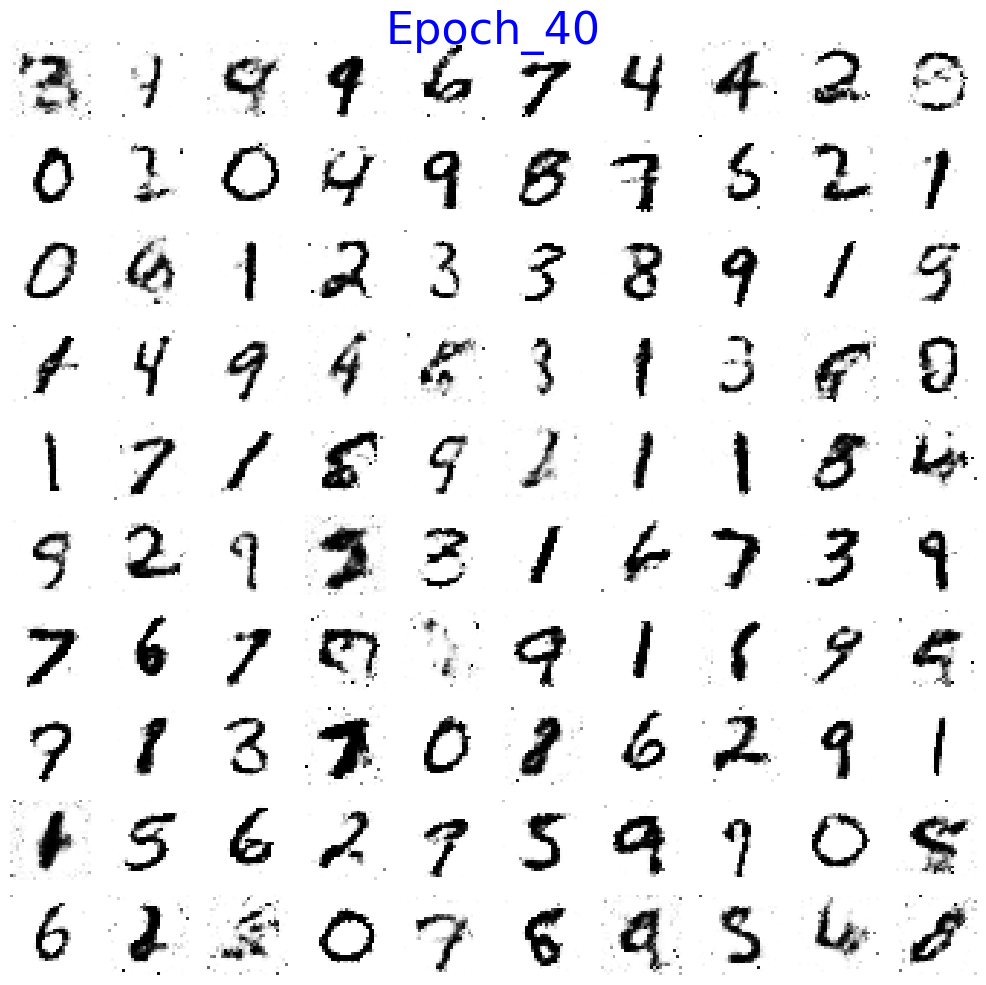

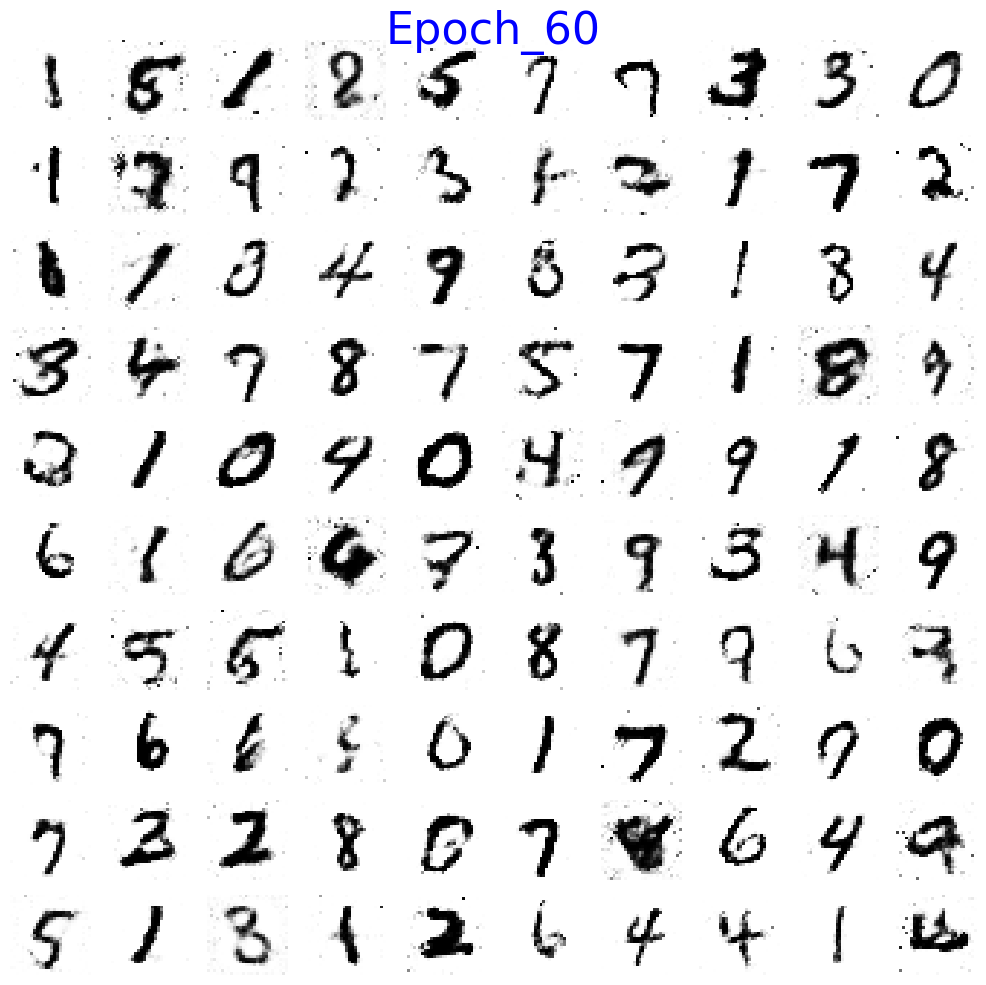

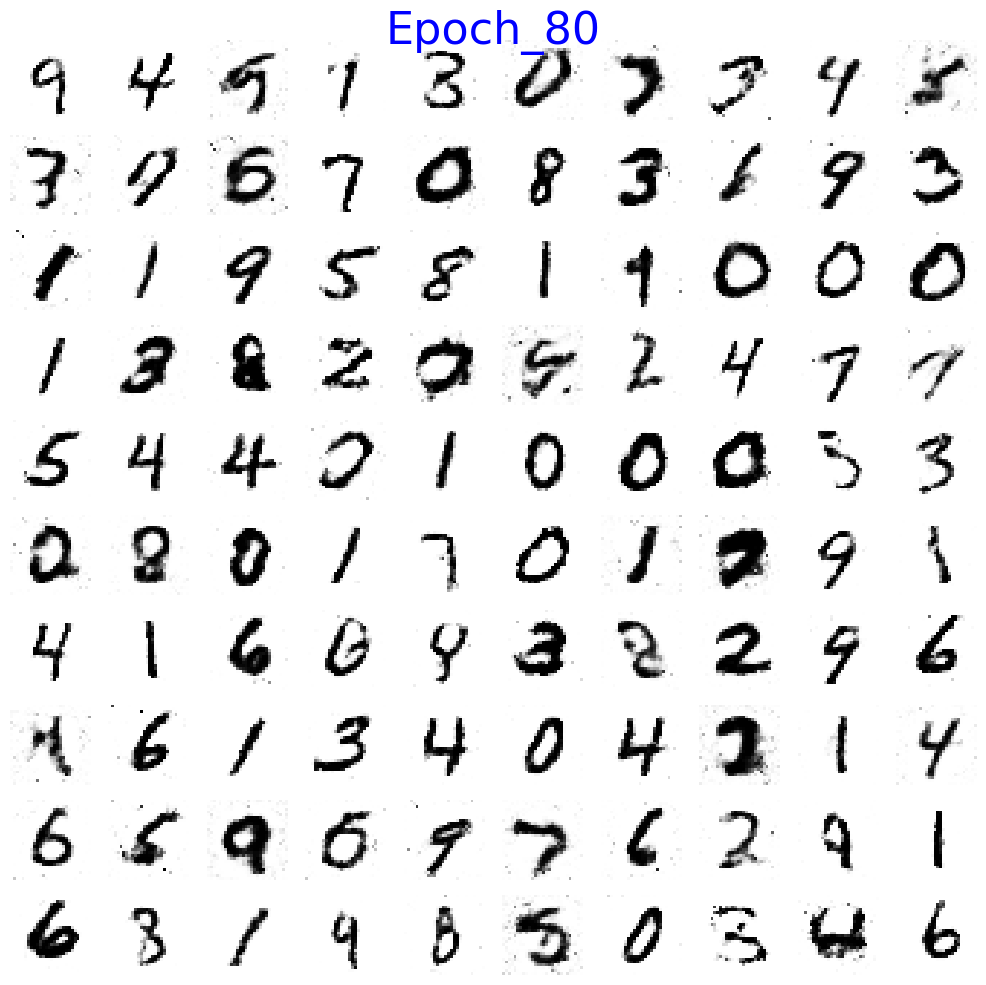

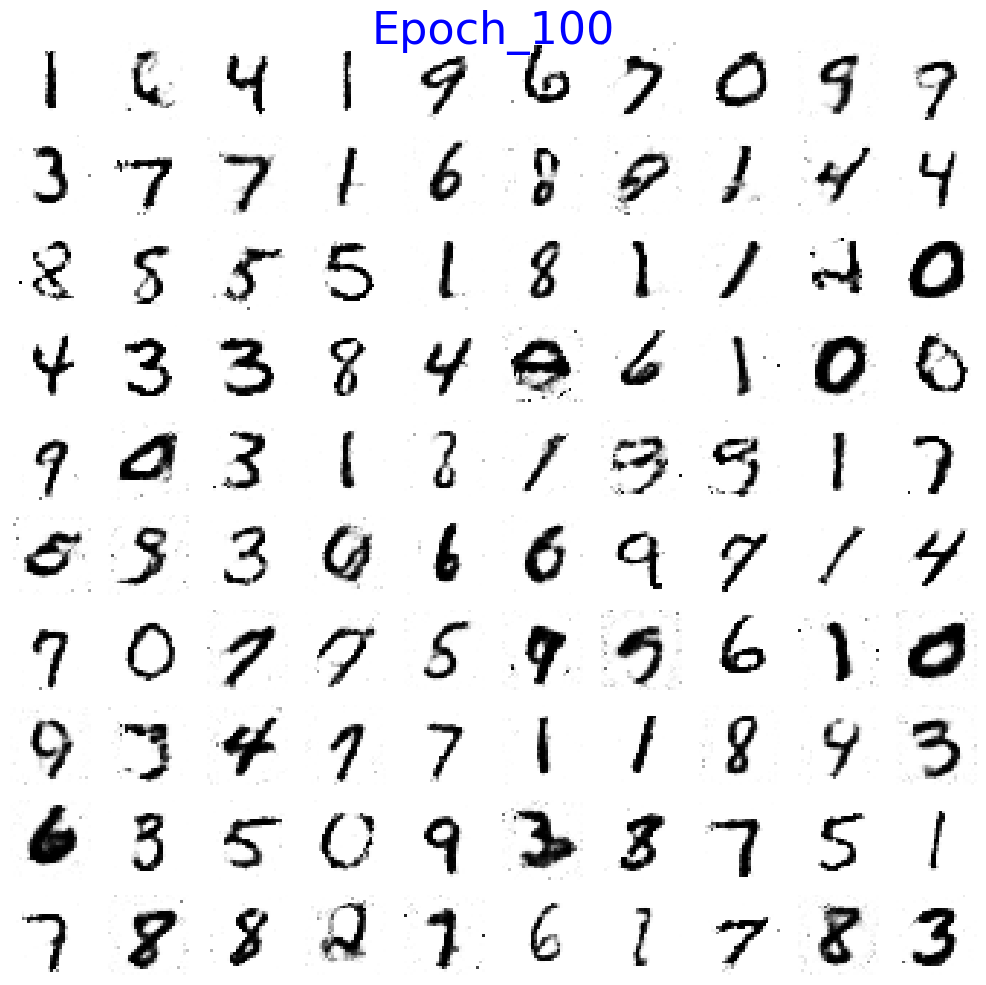

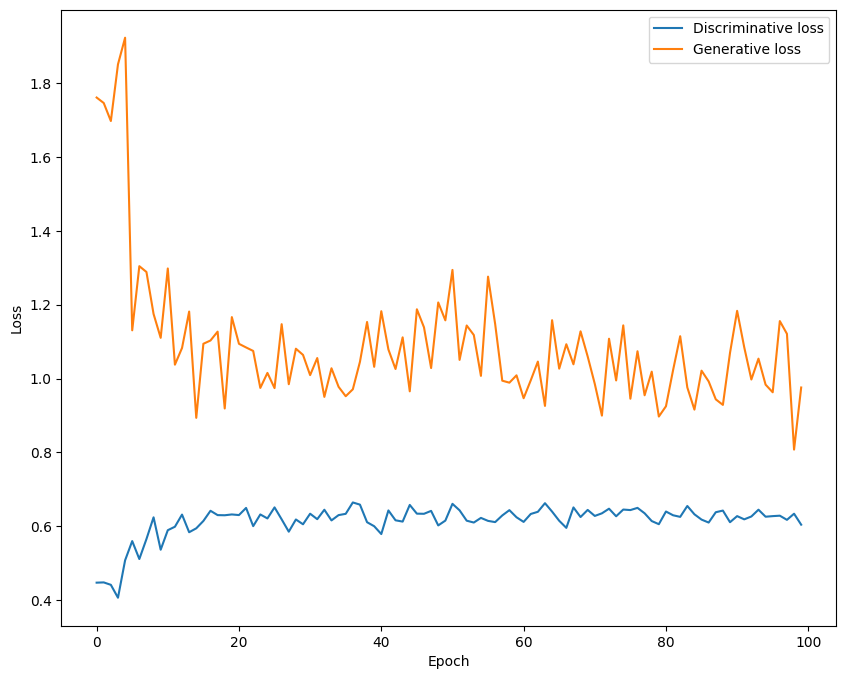

In [8]:
train(100, 128)